In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=False)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion_FixedVer_TrainTest/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


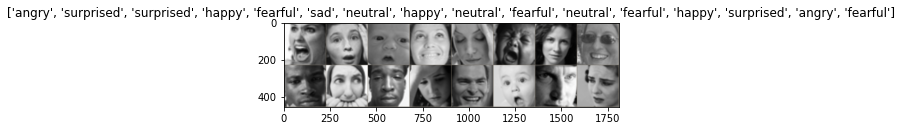

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.0001_adam_batch16_epoch20_pretrainFalse.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/1248], Loss: 6.6144
Epoch [1/30], Step [20/1248], Loss: 1.6875
Epoch [1/30], Step [40/1248], Loss: 1.9851
Epoch [1/30], Step [60/1248], Loss: 2.0412
Epoch [1/30], Step [80/1248], Loss: 1.9255
Epoch [1/30], Step [100/1248], Loss: 1.9113
Epoch [1/30], Step [120/1248], Loss: 1.8630
Epoch [1/30], Step [140/1248], Loss: 1.9320
Epoch [1/30], Step [160/1248], Loss: 1.7658
Epoch [1/30], Step [180/1248], Loss: 1.7114
Epoch [1/30], Step [200/1248], Loss: 1.8764
Epoch [1/30], Step [220/1248], Loss: 1.7872
Epoch [1/30], Step [240/1248], Loss: 2.0652
Epoch [1/30], Step [260/1248], Loss: 1.7502
Epoch [1/30], Step [280/1248], Loss: 1.7730
Epoch [1/30], Step [300/1248], Loss: 1.7177
Epoch [1/30], Step [320/1248], Loss: 1.6732
Epoch [1/30], Step [340/1248], Loss: 1.8053
Epoch [1/30], Step [360/1248], Loss: 1.7652
Epoch [1/30], Step [380/1248], Loss: 1.7970
Epoch [1/30], Step [400/1248], Loss: 1.7770
Epoch [1/30], Step [420/1248], Loss: 1.6496
Epoch [1/30], Step [440/1248]

Epoch [3/30], Step [1080/1248], Loss: 1.2109
Epoch [3/30], Step [1100/1248], Loss: 1.1772
Epoch [3/30], Step [1120/1248], Loss: 0.8683
Epoch [3/30], Step [1140/1248], Loss: 1.2380
Epoch [3/30], Step [1160/1248], Loss: 1.3408
Epoch [3/30], Step [1180/1248], Loss: 1.0468
Epoch [3/30], Step [1200/1248], Loss: 0.9642
Epoch [3/30], Step [1220/1248], Loss: 1.0722
Epoch [3/30], Step [1240/1248], Loss: 1.0782

train-loss: 1.4716, train-acc: 53.6974
validation loss: 1.3696, validation acc: 57.1700

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/1248], Loss: 1.0931
Epoch [4/30], Step [20/1248], Loss: 1.1052
Epoch [4/30], Step [40/1248], Loss: 1.1378
Epoch [4/30], Step [60/1248], Loss: 1.0144
Epoch [4/30], Step [80/1248], Loss: 0.9264
Epoch [4/30], Step [100/1248], Loss: 0.9975
Epoch [4/30], Step [120/1248], Loss: 1.6171
Epoch [4/30], Step [140/1248], Loss: 1.2668
Epoch [4/30], Step [160/1248], Loss: 1.1782
Epoch [4/30], Step [180/1248], Loss: 0.6995
Epoch [4/30], Step [200/1248]

Epoch [6/30], Step [840/1248], Loss: 1.4523
Epoch [6/30], Step [860/1248], Loss: 0.9803
Epoch [6/30], Step [880/1248], Loss: 1.3248
Epoch [6/30], Step [900/1248], Loss: 1.0106
Epoch [6/30], Step [920/1248], Loss: 1.4624
Epoch [6/30], Step [940/1248], Loss: 0.5346
Epoch [6/30], Step [960/1248], Loss: 0.9743
Epoch [6/30], Step [980/1248], Loss: 1.2120
Epoch [6/30], Step [1000/1248], Loss: 1.3377
Epoch [6/30], Step [1020/1248], Loss: 0.6923
Epoch [6/30], Step [1040/1248], Loss: 0.7576
Epoch [6/30], Step [1060/1248], Loss: 0.8508
Epoch [6/30], Step [1080/1248], Loss: 0.6165
Epoch [6/30], Step [1100/1248], Loss: 0.9758
Epoch [6/30], Step [1120/1248], Loss: 0.5447
Epoch [6/30], Step [1140/1248], Loss: 0.9817
Epoch [6/30], Step [1160/1248], Loss: 0.6712
Epoch [6/30], Step [1180/1248], Loss: 0.6215
Epoch [6/30], Step [1200/1248], Loss: 0.7264
Epoch [6/30], Step [1220/1248], Loss: 0.8998
Epoch [6/30], Step [1240/1248], Loss: 0.9189

train-loss: 1.2267, train-acc: 66.3076
validation loss: 1.1977

Epoch [9/30], Step [640/1248], Loss: 0.2734
Epoch [9/30], Step [660/1248], Loss: 0.4717
Epoch [9/30], Step [680/1248], Loss: 0.5025
Epoch [9/30], Step [700/1248], Loss: 0.7089
Epoch [9/30], Step [720/1248], Loss: 0.6257
Epoch [9/30], Step [740/1248], Loss: 0.3824
Epoch [9/30], Step [760/1248], Loss: 0.3048
Epoch [9/30], Step [780/1248], Loss: 0.4833
Epoch [9/30], Step [800/1248], Loss: 0.7319
Epoch [9/30], Step [820/1248], Loss: 0.6354
Epoch [9/30], Step [840/1248], Loss: 0.8733
Epoch [9/30], Step [860/1248], Loss: 0.6856
Epoch [9/30], Step [880/1248], Loss: 0.6640
Epoch [9/30], Step [900/1248], Loss: 1.1959
Epoch [9/30], Step [920/1248], Loss: 0.5967
Epoch [9/30], Step [940/1248], Loss: 0.4626
Epoch [9/30], Step [960/1248], Loss: 0.6167
Epoch [9/30], Step [980/1248], Loss: 0.1914
Epoch [9/30], Step [1000/1248], Loss: 0.2936
Epoch [9/30], Step [1020/1248], Loss: 0.4077
Epoch [9/30], Step [1040/1248], Loss: 0.5442
Epoch [9/30], Step [1060/1248], Loss: 0.3791
Epoch [9/30], Step [1080/124

Epoch [12/30], Step [380/1248], Loss: 0.0568
Epoch [12/30], Step [400/1248], Loss: 0.1690
Epoch [12/30], Step [420/1248], Loss: 0.3912
Epoch [12/30], Step [440/1248], Loss: 0.1772
Epoch [12/30], Step [460/1248], Loss: 0.0268
Epoch [12/30], Step [480/1248], Loss: 0.1132
Epoch [12/30], Step [500/1248], Loss: 0.5239
Epoch [12/30], Step [520/1248], Loss: 0.2237
Epoch [12/30], Step [540/1248], Loss: 0.0952
Epoch [12/30], Step [560/1248], Loss: 0.3125
Epoch [12/30], Step [580/1248], Loss: 0.2908
Epoch [12/30], Step [600/1248], Loss: 0.8341
Epoch [12/30], Step [620/1248], Loss: 0.2342
Epoch [12/30], Step [640/1248], Loss: 0.4482
Epoch [12/30], Step [660/1248], Loss: 0.1443
Epoch [12/30], Step [680/1248], Loss: 0.1218
Epoch [12/30], Step [700/1248], Loss: 0.0496
Epoch [12/30], Step [720/1248], Loss: 0.2485
Epoch [12/30], Step [740/1248], Loss: 0.4365
Epoch [12/30], Step [760/1248], Loss: 0.1412
Epoch [12/30], Step [780/1248], Loss: 0.3236
Epoch [12/30], Step [800/1248], Loss: 0.4883
Epoch [12/

Epoch [15/30], Step [100/1248], Loss: 0.0479
Epoch [15/30], Step [120/1248], Loss: 0.0667
Epoch [15/30], Step [140/1248], Loss: 0.1338
Epoch [15/30], Step [160/1248], Loss: 0.1193
Epoch [15/30], Step [180/1248], Loss: 0.0358
Epoch [15/30], Step [200/1248], Loss: 0.1616
Epoch [15/30], Step [220/1248], Loss: 0.1455
Epoch [15/30], Step [240/1248], Loss: 0.0572
Epoch [15/30], Step [260/1248], Loss: 0.1695
Epoch [15/30], Step [280/1248], Loss: 0.0493
Epoch [15/30], Step [300/1248], Loss: 0.0487
Epoch [15/30], Step [320/1248], Loss: 0.1107
Epoch [15/30], Step [340/1248], Loss: 0.0756
Epoch [15/30], Step [360/1248], Loss: 0.0706
Epoch [15/30], Step [380/1248], Loss: 0.2236
Epoch [15/30], Step [400/1248], Loss: 0.4007
Epoch [15/30], Step [420/1248], Loss: 0.5505
Epoch [15/30], Step [440/1248], Loss: 0.1504
Epoch [15/30], Step [460/1248], Loss: 0.0661
Epoch [15/30], Step [480/1248], Loss: 0.1166
Epoch [15/30], Step [500/1248], Loss: 0.1637
Epoch [15/30], Step [520/1248], Loss: 0.0798
Epoch [15/

Epoch [17/30], Step [1140/1248], Loss: 0.1357
Epoch [17/30], Step [1160/1248], Loss: 0.2376
Epoch [17/30], Step [1180/1248], Loss: 0.0297
Epoch [17/30], Step [1200/1248], Loss: 0.0572
Epoch [17/30], Step [1220/1248], Loss: 0.1329
Epoch [17/30], Step [1240/1248], Loss: 0.3065

train-loss: 0.6622, train-acc: 95.0752
validation loss: 1.3356, validation acc: 62.6581

Epoch 18

Epoch [18/30], Step [0/1248], Loss: 0.0824
Epoch [18/30], Step [20/1248], Loss: 0.1153
Epoch [18/30], Step [40/1248], Loss: 0.0479
Epoch [18/30], Step [60/1248], Loss: 0.0611
Epoch [18/30], Step [80/1248], Loss: 0.4251
Epoch [18/30], Step [100/1248], Loss: 0.0452
Epoch [18/30], Step [120/1248], Loss: 0.0088
Epoch [18/30], Step [140/1248], Loss: 0.0169
Epoch [18/30], Step [160/1248], Loss: 0.0176
Epoch [18/30], Step [180/1248], Loss: 0.0939
Epoch [18/30], Step [200/1248], Loss: 0.2971
Epoch [18/30], Step [220/1248], Loss: 0.0215
Epoch [18/30], Step [240/1248], Loss: 0.1666
Epoch [18/30], Step [260/1248], Loss: 0.1022


Epoch [20/30], Step [880/1248], Loss: 0.5254
Epoch [20/30], Step [900/1248], Loss: 0.3455
Epoch [20/30], Step [920/1248], Loss: 0.2569
Epoch [20/30], Step [940/1248], Loss: 0.1023
Epoch [20/30], Step [960/1248], Loss: 0.0543
Epoch [20/30], Step [980/1248], Loss: 0.4600
Epoch [20/30], Step [1000/1248], Loss: 0.1832
Epoch [20/30], Step [1020/1248], Loss: 0.2170
Epoch [20/30], Step [1040/1248], Loss: 0.0234
Epoch [20/30], Step [1060/1248], Loss: 0.3050
Epoch [20/30], Step [1080/1248], Loss: 0.0868
Epoch [20/30], Step [1100/1248], Loss: 0.1865
Epoch [20/30], Step [1120/1248], Loss: 0.0924
Epoch [20/30], Step [1140/1248], Loss: 0.2492
Epoch [20/30], Step [1160/1248], Loss: 0.1144
Epoch [20/30], Step [1180/1248], Loss: 0.0633
Epoch [20/30], Step [1200/1248], Loss: 0.0579
Epoch [20/30], Step [1220/1248], Loss: 0.1800
Epoch [20/30], Step [1240/1248], Loss: 0.2020

train-loss: 0.5824, train-acc: 95.6012
validation loss: 1.3995, validation acc: 62.7972

Epoch 21

Epoch [21/30], Step [0/1248], Lo

Epoch [23/30], Step [600/1248], Loss: 0.1609
Epoch [23/30], Step [620/1248], Loss: 0.1842
Epoch [23/30], Step [640/1248], Loss: 0.0236
Epoch [23/30], Step [660/1248], Loss: 0.0310
Epoch [23/30], Step [680/1248], Loss: 0.0861
Epoch [23/30], Step [700/1248], Loss: 0.0361
Epoch [23/30], Step [720/1248], Loss: 0.0873
Epoch [23/30], Step [740/1248], Loss: 0.0972
Epoch [23/30], Step [760/1248], Loss: 0.0108
Epoch [23/30], Step [780/1248], Loss: 0.0232
Epoch [23/30], Step [800/1248], Loss: 0.0196
Epoch [23/30], Step [820/1248], Loss: 0.1097
Epoch [23/30], Step [840/1248], Loss: 0.1721
Epoch [23/30], Step [860/1248], Loss: 0.0286
Epoch [23/30], Step [880/1248], Loss: 0.0891
Epoch [23/30], Step [900/1248], Loss: 0.0802
Epoch [23/30], Step [920/1248], Loss: 0.0103
Epoch [23/30], Step [940/1248], Loss: 0.0149
Epoch [23/30], Step [960/1248], Loss: 0.0411
Epoch [23/30], Step [980/1248], Loss: 0.0299
Epoch [23/30], Step [1000/1248], Loss: 0.1062
Epoch [23/30], Step [1020/1248], Loss: 0.0587
Epoch [2

Epoch [26/30], Step [320/1248], Loss: 0.0148
Epoch [26/30], Step [340/1248], Loss: 0.1883
Epoch [26/30], Step [360/1248], Loss: 0.0835
Epoch [26/30], Step [380/1248], Loss: 0.0565
Epoch [26/30], Step [400/1248], Loss: 0.0203
Epoch [26/30], Step [420/1248], Loss: 0.0323
Epoch [26/30], Step [440/1248], Loss: 0.0033
Epoch [26/30], Step [460/1248], Loss: 0.0051
Epoch [26/30], Step [480/1248], Loss: 0.0829
Epoch [26/30], Step [500/1248], Loss: 0.2209
Epoch [26/30], Step [520/1248], Loss: 0.0677
Epoch [26/30], Step [540/1248], Loss: 0.0042
Epoch [26/30], Step [560/1248], Loss: 0.0106
Epoch [26/30], Step [580/1248], Loss: 0.0052
Epoch [26/30], Step [600/1248], Loss: 0.0389
Epoch [26/30], Step [620/1248], Loss: 0.0416
Epoch [26/30], Step [640/1248], Loss: 0.1962
Epoch [26/30], Step [660/1248], Loss: 0.1411
Epoch [26/30], Step [680/1248], Loss: 0.0086
Epoch [26/30], Step [700/1248], Loss: 0.0130
Epoch [26/30], Step [720/1248], Loss: 0.0088
Epoch [26/30], Step [740/1248], Loss: 0.0613
Epoch [26/

Epoch [29/30], Step [40/1248], Loss: 0.1201
Epoch [29/30], Step [60/1248], Loss: 0.0349
Epoch [29/30], Step [80/1248], Loss: 0.0518
Epoch [29/30], Step [100/1248], Loss: 0.0024
Epoch [29/30], Step [120/1248], Loss: 0.1082
Epoch [29/30], Step [140/1248], Loss: 0.0045
Epoch [29/30], Step [160/1248], Loss: 0.0119
Epoch [29/30], Step [180/1248], Loss: 0.0141
Epoch [29/30], Step [200/1248], Loss: 0.0083
Epoch [29/30], Step [220/1248], Loss: 0.0026
Epoch [29/30], Step [240/1248], Loss: 0.0065
Epoch [29/30], Step [260/1248], Loss: 0.0059
Epoch [29/30], Step [280/1248], Loss: 0.0059
Epoch [29/30], Step [300/1248], Loss: 0.3298
Epoch [29/30], Step [320/1248], Loss: 0.0495
Epoch [29/30], Step [340/1248], Loss: 0.2630
Epoch [29/30], Step [360/1248], Loss: 0.0244
Epoch [29/30], Step [380/1248], Loss: 0.0532
Epoch [29/30], Step [400/1248], Loss: 0.1190
Epoch [29/30], Step [420/1248], Loss: 0.0275
Epoch [29/30], Step [440/1248], Loss: 0.0020
Epoch [29/30], Step [460/1248], Loss: 0.2648
Epoch [29/30]

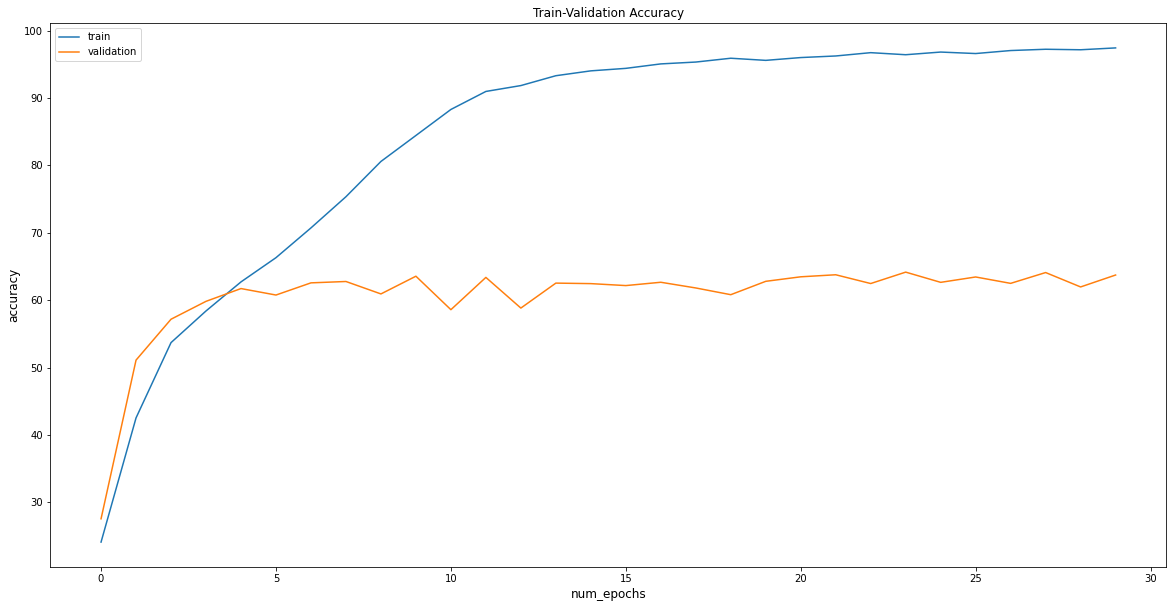

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

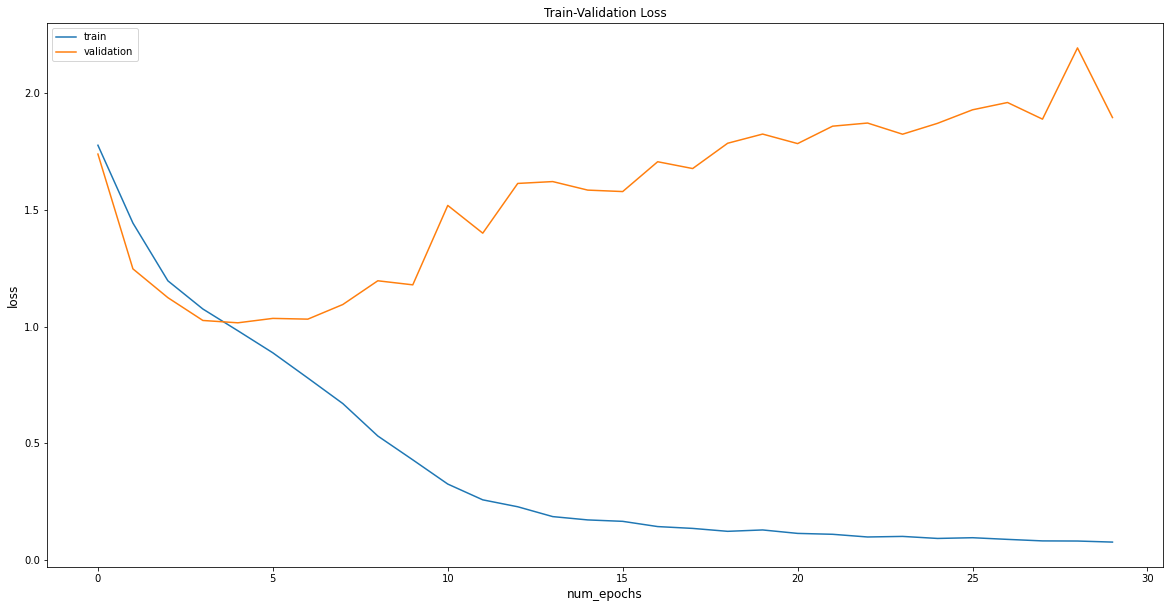

In [10]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

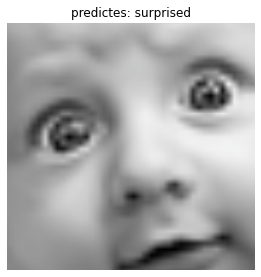

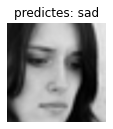

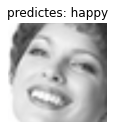

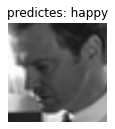

In [11]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()